In [1]:
# used for submission variables
from copy import deepcopy

## Sentinel-2 tile download


In [2]:
# KEEP
from dynaconf import Dynaconf

settings = Dynaconf(
    envvar_prefix="IP4RS",
    settings_files=["settings.toml", ".secrets.toml"],
)

SENTINEL_API_URL = "https://scihub.copernicus.eu/dhus"
YOUR_USERNAME = "oliverstoll2"
YOUR_PWD = ""
user = settings.get("scihub_copernicus_user", default=YOUR_USERNAME)
pwd = settings.get("scihub_copernicus_pwd", default=YOUR_PWD)

assert user != r""
assert pwd != r""
###

In [3]:
# imports
import numpy as np
import geopandas
from pathlib import Path
import osmnx


from sentinelsat import SentinelAPI
from datetime import date
from shapely.geometry import Point

from enum import Enum
from typing import List
import matplotlib.pyplot as plt

In [4]:
import rasterio
import rasterio.mask

In [5]:
# get point of interest
latitude = 52.512230
longitude = 13.327135
series = geopandas.GeoSeries([Point(longitude, latitude)], crs="EPSG:4326")
series.to_wkt()
poi = series.to_wkt()[0]
poi

'POINT (13.327135 52.51223)'

In [6]:
# create api query and query the point of interest
api_sent = SentinelAPI(user, pwd, SENTINEL_API_URL)

start_date = date(year=2022, month=3, day=1)
end_date = date(year=2022, month=4, day=30)
satellite = "Sentinel-2"
producttype = "S2MSI2A"

products = api_sent.query(
    poi,
    date=(start_date, end_date),
    platformname=satellite,
    producttype=producttype,
    cloudcoverpercentage=(1, 10),
)
products_gdf = api_sent.to_geodataframe(products)
assert not products_gdf.empty
# sort and select the first row
product = products_gdf.sort_values(
    ["cloudcoverpercentage", "ingestiondate"], ascending=[True, True]
).head(1)
product.index[0]

'6e72989f-428a-4434-96ab-f576830e20e1'

In [7]:
# download file
download_dir = Path("./data")
download_dir.mkdir(exist_ok=True)

output_file = download_dir / f"{product.title[0]}.zip"
if not output_file.exists():
    api_sent.download_all(product.index, directory_path=download_dir)

In [8]:
# The tile-id should be generated here
tile_id = product.index[0]
tile_id

'6e72989f-428a-4434-96ab-f576830e20e1'

In [9]:
### DO NOT EDIT
submission_tile_id = deepcopy(tile_id)
##

In [10]:
# https://scihub.copernicus.eu/dhus/odata/v1/Products('6e72989f-428a-4434-96ab-f576830e20e1')/$value

## Valid sub-region

From the previously downloaded tile, extract a _valid_ subregion.
Convert the subregion to a `uint8` array without dropping important information (i.e., not simply calling `np.uint8` on the input).

In [11]:
# extract data
unzipped_dir = output_file.with_suffix(".SAFE")
assert unzipped_dir.exists()

In [12]:
# working with data
class Band(str, Enum):
    """A collection of different Sentinel-2 band names."""

    B01 = "B01"
    B02 = "B02"
    B03 = "B03"
    B04 = "B04"
    B05 = "B05"
    B06 = "B06"
    B07 = "B07"
    B08 = "B08"
    B8A = "B8A"
    B09 = "B09"
    B10 = "B10"
    B11 = "B11"
    B12 = "B12"

    def __str__(self):
        return self.value

AVAILABLE_BANDS = (
    Band.B01,
    Band.B02,
    Band.B03,
    Band.B04,
    Band.B05,
    Band.B06,
    Band.B07,
    Band.B8A,
    Band.B09,
    Band.B11,
    Band.B12,
)


def read_s2_jp2_data(jp2_data_path: Path) -> np.ndarray:
    """
    Read band from Sentinel-2 jp2 file.
    """
    with rasterio.open(jp2_data_path) as data:
        # rasterio is 1-indexed
        return data.read(1)


def _get_all_jp2_files(source_dir: Path, parent_dir: str = "IMG_DATA/R60m") -> List[Path]:
    """
    Given a Sentinel-2 source directory, find all jp2 files that have
    a parent folder named `parent_dir`.
    Usually, it should be the folder `IMG_DATA`, other possible source
    would be the quality masks in `QI_DATA`.
    To not load band multiple times at different resolutions, by default
    the lowest 60m band is loaded.

    Note: Depending on the acquisition date and data type, the structure might be different
    and no sub-directory within `IMG_DATA` exists!
    """
    image_files = list(source_dir.glob(f"**/{parent_dir}/*.jp2"))
    assert len(image_files) > 0
    return image_files


class S2_TileReader:
    def __init__(self, safe_directory: Path, img_data_parent_dir: str = "IMG_DATA/R60m"):
        self.image_files = _get_all_jp2_files(safe_directory, parent_dir=img_data_parent_dir)

    def _get_band_path(self, band: Band) -> Path:
        return [f for f in self.image_files if f"_{band}_" in f.name][0]

    def read_band_data(self, band: Band) -> np.ndarray:
        band_path = self._get_band_path(band)
        return read_s2_jp2_data(band_path)

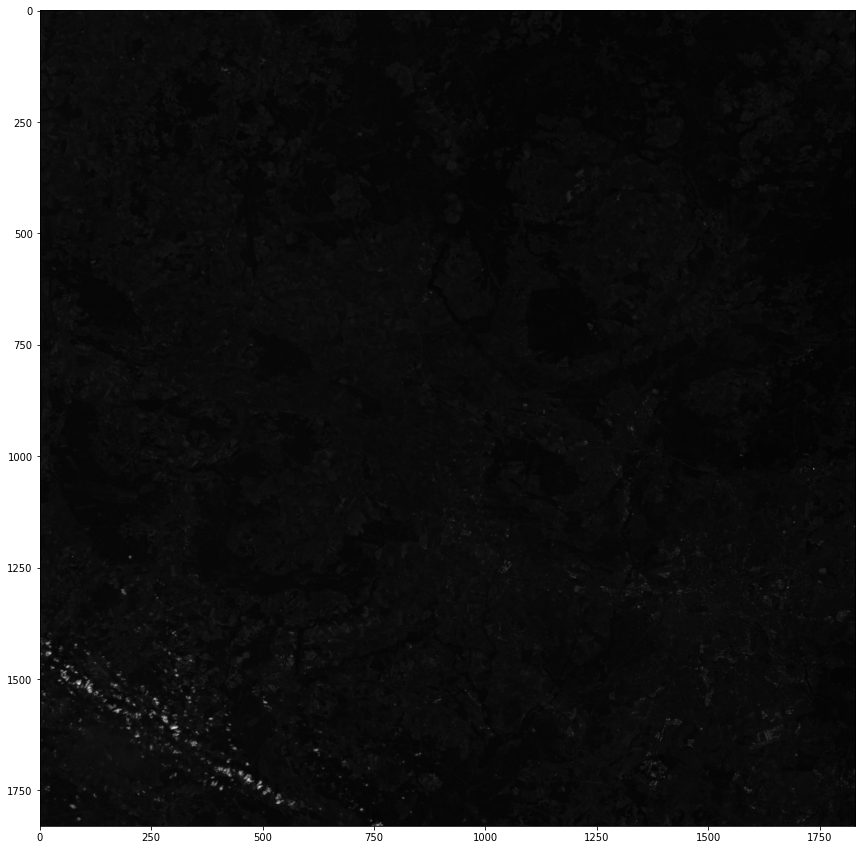

In [13]:
# get data from band
s2_reader = S2_TileReader(unzipped_dir)
band03_data = s2_reader.read_band_data(Band.B01)

# visualize full data
band03_data.min(), band03_data.max(), band03_data.shape, band03_data.dtype
plt.figure(figsize=(15, 15))
plt.imshow(band03_data, cmap="gray")

In [14]:
# get subregion of berlin
berlin_gdf = osmnx.geocode_to_gdf("Berlin")
# print(berlin_gdf)
berlin_gdf

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance
0,"MULTIPOLYGON (((13.08835 52.41963, 13.09021 52...",52.675509,52.338245,13.761161,13.088345,281709287,relation,62422,52.506935,13.397483,"Berlin, Germany",boundary,administrative,0.897539


In [15]:
# get subregion
def read_s2_jp2_data_with_clipping(
    band_data_path: Path, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
) -> np.ndarray:
    with rasterio.open(band_data_path) as data:
        # ensure that the data is using the same coordinate reference system
        reprojected_geoseries = clip_geoseries.to_crs(data.crs)
        reprojected_geoseries = (
            reprojected_geoseries.envelope if envelope else reprojected_geoseries
        )
        out_img, _out_transform = rasterio.mask.mask(data, reprojected_geoseries, crop=True)
        # drop singleton axes
        out_img = out_img.squeeze()
    return out_img

class S2_TileReader:
    def __init__(self, safe_directory: Path, img_data_parent_dir: str = "IMG_DATA/R60m"):
        self.image_files = _get_all_jp2_files(safe_directory, parent_dir=img_data_parent_dir)

    def _get_band_path(self, band: Band) -> Path:
        print(band)
        return [f for f in self.image_files if f"_{band}_" in f.name][0]

    def read_band_data(self, band: Band) -> np.ndarray:
        band_path = self._get_band_path(band)
        return read_s2_jp2_data(band_path)

    def read_band_data_with_clipping(
        self, band: Band, clip_geoseries: geopandas.GeoSeries, envelope: bool = True
    ) -> np.ndarray:
        band_path = self._get_band_path(band)
        return read_s2_jp2_data_with_clipping(band_path, clip_geoseries, envelope=envelope)

In [16]:
AVAILABLE_BANDS

(<Band.B01: 'B01'>,
 <Band.B02: 'B02'>,
 <Band.B03: 'B03'>,
 <Band.B04: 'B04'>,
 <Band.B05: 'B05'>,
 <Band.B06: 'B06'>,
 <Band.B07: 'B07'>,
 <Band.B8A: 'B8A'>,
 <Band.B09: 'B09'>,
 <Band.B11: 'B11'>,
 <Band.B12: 'B12'>)

In [17]:
# re-initialize
s2_reader = S2_TileReader(unzipped_dir)

all_clipped_band_data = np.stack(
    [s2_reader.read_band_data_with_clipping(b, berlin_gdf.geometry) for b in AVAILABLE_BANDS],
    axis=-1,
)

all_clipped_band_data

B01
B02
B03
B04
B05
B06
B07
B8A
B09
B11
B12


array([[[   0,    0,    0, ...,    0,    0,    0],
        [1095, 1154, 1244, ..., 2727, 1955, 1516],
        [1076, 1135, 1226, ..., 2821, 1830, 1419],
        ...,
        [1280, 1440, 1714, ..., 4132, 3124, 2457],
        [1266, 1407, 1681, ..., 4012, 3021, 2347],
        [1029, 1304, 1552, ..., 3556, 2761, 2175]],

       [[   0,    0,    0, ...,    0,    0,    0],
        [1079, 1173, 1280, ..., 2767, 2119, 1618],
        [1080, 1176, 1293, ..., 2984, 2097, 1585],
        ...,
        [1266, 1425, 1681, ..., 4031, 3033, 2359],
        [1291, 1437, 1703, ..., 3977, 3079, 2408],
        [1034, 1324, 1569, ..., 3776, 2897, 2268]],

       [[   0,    0,    0, ...,    0,    0,    0],
        [1102, 1166, 1264, ..., 2676, 1992, 1548],
        [1121, 1228, 1340, ..., 2873, 2388, 1829],
        ...,
        [1293, 1466, 1743, ..., 3971, 3235, 2570],
        [1324, 1511, 1785, ..., 3902, 3405, 2734],
        [1045, 1360, 1602, ..., 3868, 3157, 2481]],

       ...,

       [[   0,    0,    

In [18]:
# convert to uint8
clipped_float = (all_clipped_band_data + 1_000) / 10_000
clipped_float = np.clip(clipped_float, 0.0, 1.0)
clipped_uint = np.uint8(clipped_float * 255)
clipped_uint

array([[[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  54,  57, ...,  95,  75,  64],
        [ 52,  54,  56, ...,  97,  72,  61],
        ...,
        [ 58,  62,  69, ..., 130, 105,  88],
        [ 57,  61,  68, ..., 127, 102,  85],
        [ 51,  58,  65, ..., 116,  95,  80]],

       [[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  55,  58, ...,  96,  79,  66],
        [ 53,  55,  58, ..., 101,  78,  65],
        ...,
        [ 57,  61,  68, ..., 128, 102,  85],
        [ 58,  62,  68, ..., 126, 104,  86],
        [ 51,  59,  65, ..., 121,  99,  83]],

       [[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  55,  57, ...,  93,  76,  64],
        [ 54,  56,  59, ...,  98,  86,  72],
        ...,
        [ 58,  62,  69, ..., 126, 107,  91],
        [ 59,  64,  71, ..., 125, 112,  95],
        [ 52,  60,  66, ..., 124, 106,  88]],

       ...,

       [[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  55,  58, ..., 106,  78,  66],
        [ 53,  55,  59, ..., 108,  78,  65

In [19]:
### Add here the code to select a valid subregion

subregion_uint8 = clipped_uint

In [20]:
### DO NOT EDIT
submission_subregion_uint8 = deepcopy(subregion_uint8)
###

### Visualize the valid sub-region

Visualize a _single band_ from the valid subregion _without_ applying any explicit or implicit normalization strategy.
The input array passed to `plt.imshow` has to be in the range `[0, 255]`. This range should also be reflected in the `vmin/vmax` parameters.

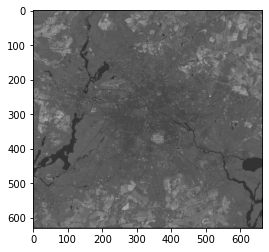

In [21]:
# Add the code to visualize the single band
# without normalization here:

# imshow_inp is the array that should be passed to plt.imshow
imshow_inp = subregion_uint8[..., 7].copy()

plt.imshow(imshow_inp, cmap='gray', vmin=0, vmax=255)

In [22]:
# DO NOT EDIT
submission_imshow_inp = deepcopy(imshow_inp)
###

## Morphological operators & Thresholding

The goal of this section is to combine morphological operators with thresholding strategies to create a binary/output mask that can then be used to segment the region/object of interest.
You are _not_ required to perfectly segment the object of interest. It is sufficient if the visual results _indicate_ the object of interest.

You have to meet the following requirements:
- You are _not_ allowed to use simple rectangular structuring elements.
- The values of the output mask must either be 0 or 1
    - 0 is used to indicate the absence of the object
    - 1 is used to indicate the presence of the object

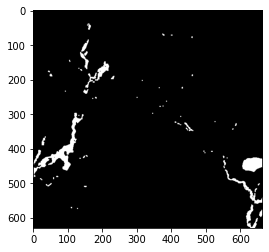

In [23]:
# Add code here to apply morphological operators and thresholding strategy. You are allowed to change/mix the order

from scipy import ndimage

threshold = 70
kernel = np.ones((3,3))

mask = np.where(imshow_inp > threshold, 0, 255)
mask = ndimage.grey_opening(mask, footprint=kernel)

mask = np.where(mask < threshold, 0, 255)

plt.imshow(mask, cmap="gray", vmin=0, vmax=255)
output_mask = mask

In [24]:
# DO NOT EDIT
submission_output_mask = deepcopy(output_mask)
###

To visually evaluate your result, use the output mask as an overlay for the RGB channels of the input array.
The colored output should be normalized to enhance the viewing experiment.
You can choose any _valid_ normalization strategy/method for the RGB channels.

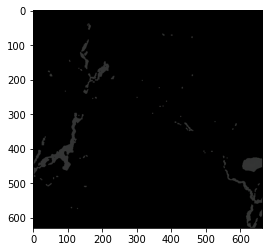

In [25]:
# Visualize the overlayed image
r = subregion_uint8[..., 3].copy()
g = subregion_uint8[..., 2].copy()
b = subregion_uint8[..., 1].copy()

img = np.stack([r, g, b], axis=-1)
img_masked = np.where(mask[..., np.newaxis], img, 0)
plt.imshow(img_masked)

51.0 61.0


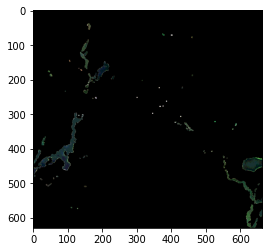

In [26]:
# now normalize by quantilizing
masked_data = np.ma.masked_equal(img_masked, 0)
lq, uq = np.quantile(masked_data.compressed(), (0.01, 0.99))
print(lq, uq)
img_clipped = np.clip(img_masked, a_min=lq, a_max=uq)
img_clipped = (img_clipped - lq) / (uq - lq)

plt.imshow(img_clipped)

In [27]:
img_masked[410:415,15:20,:]

array([[[59, 59, 58],
        [52, 54, 54],
        [52, 54, 54],
        [52, 53, 53],
        [52, 53, 53]],

       [[54, 54, 54],
        [52, 53, 54],
        [52, 53, 54],
        [52, 53, 53],
        [52, 53, 53]],

       [[53, 54, 54],
        [52, 53, 53],
        [52, 53, 53],
        [52, 53, 53],
        [52, 53, 53]],

       [[52, 53, 53],
        [52, 53, 53],
        [52, 53, 53],
        [52, 53, 53],
        [52, 53, 53]],

       [[52, 53, 53],
        [52, 53, 53],
        [52, 53, 53],
        [52, 53, 53],
        [52, 53, 53]]], dtype=uint8)

### Discussion

Discuss what you have learned when applying the morphological operators and thresholding strategies.
What didn't work? What issues did you have? What helped?
How did you decide to use the variables you have chosen?

It is not necessary to give an in-depth discussion about each value.
It should be clear, however, that you have tried different configurations and why you have decided on the current configuration.

Here you should write discussion:

During my work, I found it hard to work with an desired object that had a spectral signature similar to other objects present in the image.
I found that water as the object of interest was easier to distinguish due to it's low reflective values in higher spectral bands.
For the band to base my output mask on I chose the near-infrared band B8A, as it showed the highest difference between water reflectance values and the reflectance values of most other objects in the image.
I applied image thresholding on the uint8 values of band 8a. I determined the threshold by experimenting with different values and comparing them with images of the map of berlin to determine if the water masses were correctly categorized as included (255), while other objects were excluded (0).
A good working value that I found was 70 for the thresholding.

Afterwards, I applied the morphological operation of opening, to remove small additive noise in the mask and only include larger water masses.
This worked as expected. When comparing this operation with the closing operation, the exact oposite effect was achived, which was showing not the desired effect.

## Submission

- Follow the instructions mentioned in this notebook.
- You are _not_ allowed to install other libraries.
    - The submitted jupyter notebook should be able to run as-is on paperspace and/or the provided Docker image.
- Explain the steps that went into the decision making of the specific values.
- It is essential that each homework should be done individually!
- The notebook should have been executed once before submitting it
    - The notebook should _not_ be _cleaned_ before submitting

Each student should submit the following materials to the ISIS system:
- One `zip` file containing the jupyter notebook named as: `IP4RS2022-HW1_<NAME_SURNAME>.zip`



### Submission variables

Please ensure that these variables are correct after you have restarted your notebook and executed all cells from top to bottom.
You are _not allowed_ to modify the following cells:

In [28]:
import rich

rich.print(f"{submission_tile_id=}")
rich.print(f"{submission_subregion_uint8=}")
rich.print(f"{submission_output_mask=}")

submission_tile_id='6e72989f-428a-4434-96ab-f576830e20e1'

submission_subregion_uint8=array([[[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  54,  57, ...,  95,  75,  64],
        [ 52,  54,  56, ...,  97,  72,  61],
        ...,
        [ 58,  62,  69, ..., 130, 105,  88],
        [ 57,  61,  68, ..., 127, 102,  85],
        [ 51,  58,  65, ..., 116,  95,  80]],

       [[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  55,  58, ...,  96,  79,  66],
        [ 53,  55,  58, ..., 101,  78,  65],
        ...,
        [ 57,  61,  68, ..., 128, 102,  85],
        [ 58,  62,  68, ..., 126, 104,  86],
        [ 51,  59,  65, ..., 121,  99,  83]],

       [[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  55,  57, ...,  93,  76,  64],
        [ 54,  56,  59, ...,  98,  86,  72],
        ...,
        [ 58,  62,  69, ..., 126, 107,  91],
        [ 59,  64,  71, ..., 125, 112,  95],
        [ 52,  60,  66, ..., 124, 106,  88]],

       ...,

       [[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  55,  58, ..., 106,  78,  66],
        [ 53,  55,  59, ..., 108,  78,  65],
        ...,
        [ 51,  54,  57, ...,  98,  73,  62],
        [ 52,  54,  57, ...,  99,  72,  61],
        [ 47,  54,  57, ...,  97,  74,  63]],

       [[ 25,  25,  25, ...,  25,  25,  25],
        [ 53,  57,  60, ...,  99,  90,  76],
        [ 54,  57,  60, ...,  96,  92,  77],
        ...,
        [ 51,  54,  57, ...,  99,  72,  62],
        [ 52,  54,  57, ...,  99,  73,  62],
        [ 47,  54,  56, ...,  95,  73,  62]],

       [[ 25,  25,  25, ...,  25,  25,  25],
        [ 25,  25,  25, ...,  25,  25,  25],
        [ 25,  25,  25, ...,  25,  25,  25],
        ...,
        [ 25,  25,  25, ...,  25,  25,  25],
        [ 25,  25,  25, ...,  25,  25,  25],
        [ 25,  25,  25, ...,  25,  25,  25]]], dtype=uint8)

submission_output_mask=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])